# NB 02: Genus Abundance Matrix

Build a genus × site relative abundance matrix from ENIGMA ASV data.
Identify which Fitness Browser genera are present at Oak Ridge.

**Run locally** — uses extracted data from NB01.

**Outputs**: `data/genus_abundance.tsv`, `data/fb_genus_mapping.tsv`, 1 figure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [2]:
# ASV counts (filtered to 108 overlap samples)
asv_counts = pd.read_csv(DATA_DIR / 'asv_counts.tsv', sep='\t')
print(f"ASV counts: {len(asv_counts):,} rows")

# ASV taxonomy (genus + phylum)
asv_tax = pd.read_csv(DATA_DIR / 'asv_taxonomy.tsv', sep='\t')
print(f"ASV taxonomy: {len(asv_tax):,} ASVs with genus")

# Geochemistry (for sample list)
geochem = pd.read_csv(DATA_DIR / 'site_geochemistry.tsv', sep='\t', index_col=0)
print(f"Geochemistry: {len(geochem)} samples")

# FB organism mapping
org_map = pd.read_csv(
    '../../conservation_vs_fitness/data/organism_mapping.tsv',
    sep='\t'
)
fb_genera = org_map[['orgId', 'genus']].drop_duplicates()
print(f"FB organisms: {len(fb_genera)} orgId-genus pairs, {fb_genera['genus'].nunique()} unique genera")

ASV counts: 132,356 rows
ASV taxonomy: 96,822 ASVs with genus
Geochemistry: 108 samples
FB organisms: 44 orgId-genus pairs, 26 unique genera


## 2. Aggregate ASV Counts to Genus Level

In [3]:
# Join ASV counts with taxonomy
counts_with_tax = asv_counts.merge(
    asv_tax[['sdt_asv_name', 'genus']],
    on='sdt_asv_name',
    how='left'
)
print(f"Counts with taxonomy: {len(counts_with_tax):,}")
print(f"  With genus: {counts_with_tax['genus'].notna().sum():,} ({counts_with_tax['genus'].notna().mean()*100:.1f}%)")
print(f"  Without genus: {counts_with_tax['genus'].isna().sum():,}")

# Aggregate to genus level per sample
# Multiple communities per sample possible -- sum across communities
genus_counts = counts_with_tax.groupby(
    ['sdt_sample_name', 'genus']
)['read_count'].sum().reset_index()
print(f"\nGenus-level counts: {len(genus_counts):,} (sample x genus combinations)")
print(f"  Samples: {genus_counts['sdt_sample_name'].nunique()}")
print(f"  Genera: {genus_counts['genus'].nunique()}")

Counts with taxonomy: 132,356
  With genus: 114,772 (86.7%)
  Without genus: 17,584

Genus-level counts: 27,893 (sample x genus combinations)
  Samples: 108
  Genera: 1391


In [4]:
# Compute relative abundance per sample (vectorized)
sample_totals = genus_counts.groupby('sdt_sample_name')['read_count'].sum().rename('total_reads')
genus_counts = genus_counts.merge(sample_totals, on='sdt_sample_name')
genus_counts['rel_abundance'] = genus_counts['read_count'] / genus_counts['total_reads']
genus_counts = genus_counts.drop(columns=['total_reads'])

print(f"Total reads per sample: min={sample_totals.min():,}, median={sample_totals.median():,.0f}, max={sample_totals.max():,}")

# Pivot to genus x sample matrix
genus_matrix = genus_counts.pivot_table(
    index='genus',
    columns='sdt_sample_name',
    values='rel_abundance',
    fill_value=0
)
print(f"\nGenus abundance matrix: {genus_matrix.shape[0]} genera x {genus_matrix.shape[1]} samples")

Total reads per sample: min=9,549, median=70,011, max=192,483

Genus abundance matrix: 1391 genera x 108 samples


## 3. Identify FB Genera at Oak Ridge

In [5]:
# Which FB genera are detected at Oak Ridge?
fb_genus_list = fb_genera['genus'].unique()
detected_genera = [g for g in fb_genus_list if g in genus_matrix.index]
not_detected = [g for g in fb_genus_list if g not in genus_matrix.index]

print(f"FB genera detected at Oak Ridge: {len(detected_genera)} / {len(fb_genus_list)}")
print()

# Summary for each detected genus
fb_summary = []
for g in detected_genera:
    abundances = genus_matrix.loc[g]
    n_detected = (abundances > 0).sum()
    fb_orgs = fb_genera[fb_genera['genus'] == g]['orgId'].tolist()
    fb_summary.append({
        'genus': g,
        'fb_orgIds': ', '.join(fb_orgs),
        'n_sites_detected': n_detected,
        'prevalence': n_detected / genus_matrix.shape[1] * 100,
        'mean_rel_abundance': abundances[abundances > 0].mean() * 100,
        'max_rel_abundance': abundances.max() * 100,
    })

fb_df = pd.DataFrame(fb_summary).sort_values('prevalence', ascending=False)
print("FB genera at Oak Ridge:")
print(fb_df.to_string(index=False))

if not_detected:
    print(f"\nNot detected: {', '.join(sorted(not_detected))}")

FB genera detected at Oak Ridge: 14 / 26



FB genera at Oak Ridge:
         genus                                                                                                                                    fb_orgIds  n_sites_detected  prevalence  mean_rel_abundance  max_rel_abundance
  Sphingomonas                                                                                                                                        Korea               100   92.592593            0.541521           5.817921
   Pseudomonas Putida, SyringaeB728a, SyringaeB728a_mexBdelta, WCS417, psRCH2, pseudo13_GW456_L13, pseudo1_N1B4, pseudo3_N2E3, pseudo5_N2C3_1, pseudo6_N2E2                98   90.740741            1.667397          18.033302
   Caulobacter                                                                                                                                        Caulo                89   82.407407            0.679699           6.120999
   Cupriavidus                                                              

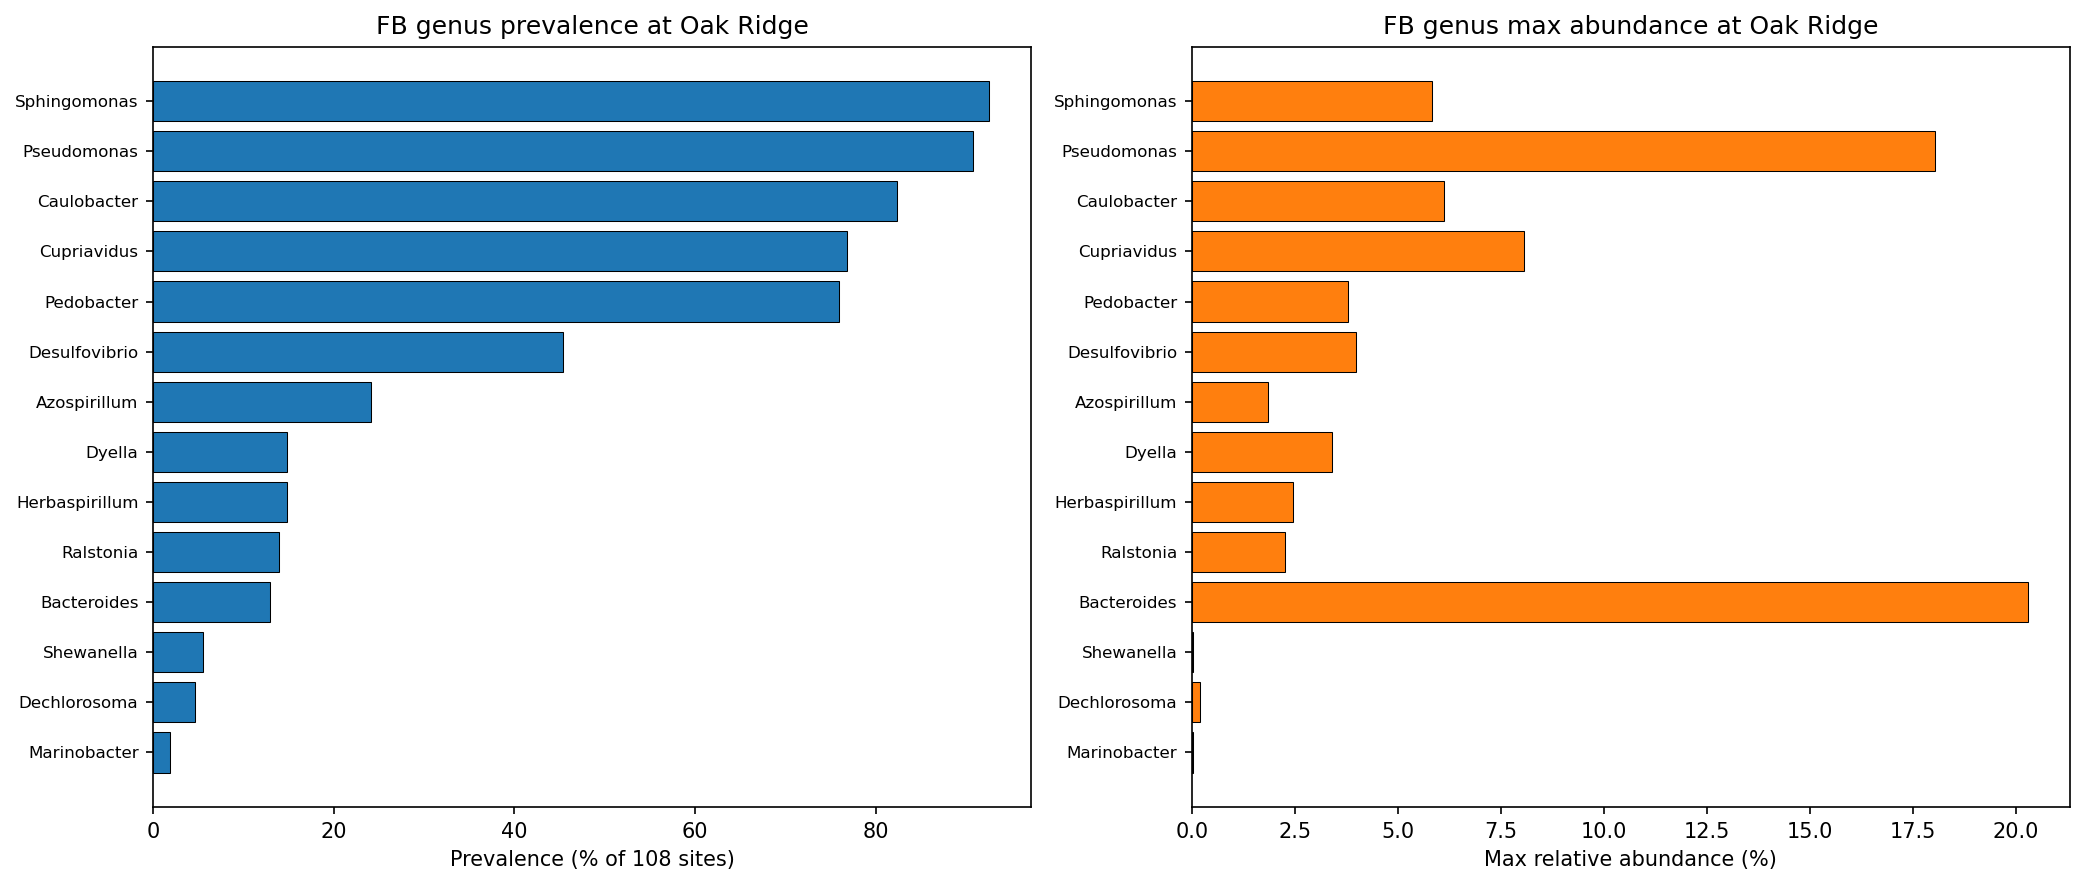

In [6]:
# Figure 1: FB genus prevalence and abundance at Oak Ridge
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_df = fb_df.sort_values('prevalence', ascending=True)

# Panel A: Prevalence (% of sites)
ax = axes[0]
ax.barh(range(len(plot_df)), plot_df['prevalence'],
        color='#1f77b4', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df['genus'], fontsize=8)
ax.set_xlabel('Prevalence (% of 108 sites)')
ax.set_title('FB genus prevalence at Oak Ridge')

# Panel B: Max relative abundance
ax = axes[1]
ax.barh(range(len(plot_df)), plot_df['max_rel_abundance'],
        color='#ff7f0e', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df['genus'], fontsize=8)
ax.set_xlabel('Max relative abundance (%)')
ax.set_title('FB genus max abundance at Oak Ridge')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_fb_genus_prevalence.png')
plt.show()

## 4. Save

In [7]:
# Save genus abundance matrix
genus_matrix.to_csv(DATA_DIR / 'genus_abundance.tsv', sep='\t')
print(f"Saved: genus_abundance.tsv ({genus_matrix.shape[0]} genera x {genus_matrix.shape[1]} samples)")

# Save FB genus mapping
fb_df.to_csv(DATA_DIR / 'fb_genus_mapping.tsv', sep='\t', index=False)
print(f"Saved: fb_genus_mapping.tsv ({len(fb_df)} FB genera)")

# Save genus counts (long format for NB03)
genus_counts.to_csv(DATA_DIR / 'genus_counts.tsv', sep='\t', index=False)
print(f"Saved: genus_counts.tsv ({len(genus_counts):,} rows)")

Saved: genus_abundance.tsv (1391 genera x 108 samples)
Saved: fb_genus_mapping.tsv (14 FB genera)
Saved: genus_counts.tsv (27,893 rows)


In [8]:
print("=" * 60)
print("NB02 SUMMARY: Genus Abundance")
print("=" * 60)
print(f"Samples: {genus_matrix.shape[1]}")
print(f"Total genera: {genus_matrix.shape[0]}")
print(f"FB genera detected: {len(detected_genera)} / {len(fb_genus_list)}")
top3 = fb_df.nlargest(3, 'prevalence')
for _, row in top3.iterrows():
    print(f"  {row['genus']}: {row['prevalence']:.0f}% prevalence, "
          f"max {row['max_rel_abundance']:.2f}% abundance")
print("=" * 60)

NB02 SUMMARY: Genus Abundance
Samples: 108
Total genera: 1391
FB genera detected: 14 / 26
  Sphingomonas: 93% prevalence, max 5.82% abundance
  Pseudomonas: 91% prevalence, max 18.03% abundance
  Caulobacter: 82% prevalence, max 6.12% abundance
